In [1]:
import os
import torch
import numpy as np
import rdkit
from rdkit import Chem
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem import AllChem
from tqdm import tqdm 
from copy import deepcopy
import warnings
from rdkit.Chem import AllChem, rdMolTransforms
warnings.filterwarnings('ignore')
import pytorch_lightning as pl

In [2]:
from torch_geometric.data import Data, Batch 
# import nglview
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from ase.visualize import view
from ase import Atoms
from xtb.ase.calculator import XTB

IPythonConsole.ipython_useSVG = True 
IPythonConsole.molSize = 300, 300
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%matplotlib notebook

In [3]:
import py3Dmol
from rdkit import Chem
from rdkit.Chem import AllChem
import ipywidgets
from ipywidgets import interact, interactive, fixed, IntSlider

In [4]:
from rdkit.Chem.rdmolops import RemoveHs
from rdkit.Chem import rdMolAlign as MA

In [5]:
def get_best_rmsd(probe, ref):
    probe = RemoveHs(probe)
    ref = RemoveHs(ref)
    rmsd = MA.GetBestRMS(probe, ref)
    return rmsd

In [6]:
def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

In [7]:
def repeat_data(data: Data, num_repeat) -> Batch:
    datas = [deepcopy(data) for i in range(num_repeat)]
    return Batch.from_data_list(datas)

def repeat_batch(batch: Batch, num_repeat) -> Batch:
    datas = batch.to_data_list()
    new_data = []
    for i in range(num_repeat):
        new_data += deepcopy(datas)
    return Batch.from_data_list(new_data)

In [8]:
from e3moldiffusion import chem
from geom.data import GeomDataModule, MolFeaturization
from geom.train_coords import Trainer

In [9]:
def enumerateTorsions(mol):
    torsionSmarts = '[!$(*#*)&!D1]~[!$(*#*)&!D1]'
    torsionQuery = Chem.MolFromSmarts(torsionSmarts)
    matches = mol.GetSubstructMatches(torsionQuery)
    torsionList = []
    for match in matches:
        idx2 = match[0]
        idx3 = match[1]
        bond = mol.GetBondBetweenAtoms(idx2, idx3)
        jAtom = mol.GetAtomWithIdx(idx2)
        kAtom = mol.GetAtomWithIdx(idx3)
        if (((jAtom.GetHybridization() != Chem.HybridizationType.SP2)
        and (jAtom.GetHybridization() != Chem.HybridizationType.SP3))
        or ((kAtom.GetHybridization() != Chem.HybridizationType.SP2)
        and (kAtom.GetHybridization() != Chem.HybridizationType.SP3))):
            continue
        for b1 in jAtom.GetBonds():
            if (b1.GetIdx() == bond.GetIdx()):
                continue
        idx1 = b1.GetOtherAtomIdx(idx2)
        for b2 in kAtom.GetBonds():
            if ((b2.GetIdx() == bond.GetIdx())
            or (b2.GetIdx() == b1.GetIdx())):
                continue
            idx4 = b2.GetOtherAtomIdx(idx3)
            # skip 3-membered rings
            if (idx4 == idx1):
                continue
            torsionList.append((idx1, idx2, idx3, idx4))
    return torsionList

In [10]:
def compute_distances(pos):
    d = torch.cdist(pos, pos)
    ids = torch.triu_indices(pos.size(0), pos.size(0), 1)
    d = torch.triu(d, diagonal=1)
    d = d[ids[0, :], ids[1, :]]
    return d

In [11]:
def compute_mmff_energy(mol):
    ff = AllChem.MMFFGetMoleculeForceField(mol, AllChem.MMFFGetMoleculeProperties(mol), confId=0)
    ff.Initialize()
    out = ff.CalcEnergy()
    return out

In [12]:
#!nvidia-smi

In [13]:
#!echo "checking if the compute node has access to the hpfs directory where data is stored."
#!ls /hpfs/projects/mlcs

In [14]:
device = "cuda:0"
# device = "cpu"

In [15]:
datapath = "/hpfs/projects/mlcs/e3moldiffusion/"
test_info_df = os.path.join(datapath, "qm9", "test_info.csv")
test_info_df = pd.read_csv(test_info_df)
smiles_to_mol_id = os.path.join(datapath, "qm9", "smiles_to_mol_id.csv")
smiles_to_mol_id = pd.read_csv(smiles_to_mol_id)
smiles_to_mol_id = {i:s for i, s in zip(smiles_to_mol_id.mol_id, smiles_to_mol_id.smiles)}
test_info_df["smiles"] = test_info_df["mol_id"].map(lambda x: smiles_to_mol_id.get(x))

In [16]:
# dataset = "qm9"
dataset = "drugs"

In [17]:
datamodule = GeomDataModule(
        batch_size=1,
        num_workers=1,
        dataset=dataset,
        env_in_init=True,
        shuffle_train=True,
        max_num_conformers=30,
        transform_args = {"create_bond_graph": True,
                          "save_smiles": True,
                          "fully_connected_edge_index": False
                         }
    )
datamodule.setup()

In [18]:
print(f"Training set. Number of structures: {len(datamodule.train_dataset)}")
print(f"Validation set. Number of structures: {len(datamodule.val_dataset)}")
print(f"Test set. Number of structures: {len(datamodule.test_dataset)}")

Training set. Number of structures: 6512131
Validation set. Number of structures: 641189
Test set. Number of structures: 103753


In [19]:
run = 0

In [20]:
model = Trainer.load_from_checkpoint(f'logs/{dataset}_coords/run{str(run)}/last.ckpt', strict=False).to(device)
model = model.eval()

In [21]:
sum(m.numel() for m in model.parameters() if m.requires_grad)

638048

In [22]:
print(model.hparams["fully_connected"],
      model.hparams["local_global_model"],
      model.hparams["cutoff_local"],
      model.hparams["cutoff_global"],
      model.hparams["num_layers"],
      model.hparams["use_bond_features"]
     )

False True 3.0 10.0 5 True


In [23]:
loader = iter(datamodule.val_dataloader(shuffle=True))

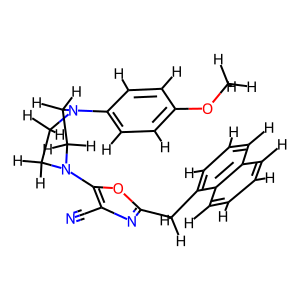

In [24]:
data = next(loader).to(device)
mol = data.mol[0]
mol

In [25]:
data.energy

tensor([[-87.7411]], device='cuda:0')

In [26]:
steps = model._hparams["num_diffusion_timesteps"]
with torch.no_grad():
    pos, traj = model.reverse_sampling(x=data.xgeom,
                                       batch=data.batch,
                                       bond_edge_index=data.edge_index,
                                       bond_edge_attr=data.edge_attr,
                                       num_diffusion_timesteps=steps,
                                       save_traj=True,
                                       verbose=True)
pos_sde_traj, pos_mean_traj = traj

range(0, 300)


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:04<00:00, 62.80it/s]


In [27]:
print(pos.isnan().sum())
print(pos.max(), pos.min())

tensor(0, device='cuda:0')
tensor(5.8548, device='cuda:0') tensor(-5.5765, device='cuda:0')


In [28]:
original_mol = deepcopy(mol)
copied_mol = deepcopy(mol)

In [29]:
# nglview.show_rdkit(original_mol)
viewer = MolTo3DView(original_mol, size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [30]:
pos = pos_sde_traj[-1]
copied_mol = chem.set_rdmol_positions(copied_mol, pos=pos.detach().cpu().numpy())
# nglview.show_rdkit(copied_mol)
viewer = MolTo3DView(copied_mol, size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [31]:
mol_trajs = [None for i in range(len(pos_sde_traj))]
for i, p in enumerate(pos_sde_traj):
    mol_trajs[i] = chem.set_rdmol_positions(deepcopy(mol), pos=p.detach().cpu().numpy())

In [32]:
def conf_viewer(idx):
    mol = mol_trajs[idx]
    return MolTo3DView(mol).show()

In [33]:
interact(conf_viewer, idx=ipywidgets.IntSlider(min=0, max=len(mol_trajs) - 1, step=2))

interactive(children=(IntSlider(value=0, description='idx', max=299, step=2), Output()), _dom_classes=('widget…

<function __main__.conf_viewer(idx)>

## Energy

In [34]:
print(compute_mmff_energy(mol=original_mol))
print(compute_mmff_energy(mol=copied_mol))

218.81626835326512
235.77547606155417


In [35]:
nrepeats = 100
batch = repeat_data(data, num_repeat=nrepeats)

In [36]:
steps = model._hparams["num_diffusion_timesteps"]
with torch.no_grad():
    pos, traj = model.reverse_sampling(x=batch.xgeom,
                                       batch=batch.batch,
                                       bond_edge_index=batch.edge_index,
                                       bond_edge_attr=batch.edge_attr,
                                       num_diffusion_timesteps=steps,
                                       save_traj=True, verbose=True)
pos_sde_traj, pos_mean_traj = traj

range(0, 300)


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 32.51it/s]


In [37]:
pos = torch.stack(pos.chunk(nrepeats, dim=0))
pos = pos.cpu()

In [38]:
mol_trajs = [None for i in range(len(pos))]
for i, p in enumerate(pos):
    mol_trajs[i] = chem.set_rdmol_positions(deepcopy(mol), pos=p.detach().cpu().numpy())

In [39]:
interact(conf_viewer, idx=ipywidgets.IntSlider(min=0, max=len(mol_trajs) - 1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=99), Output()), _dom_classes=('widget-interact…

<function __main__.conf_viewer(idx)>

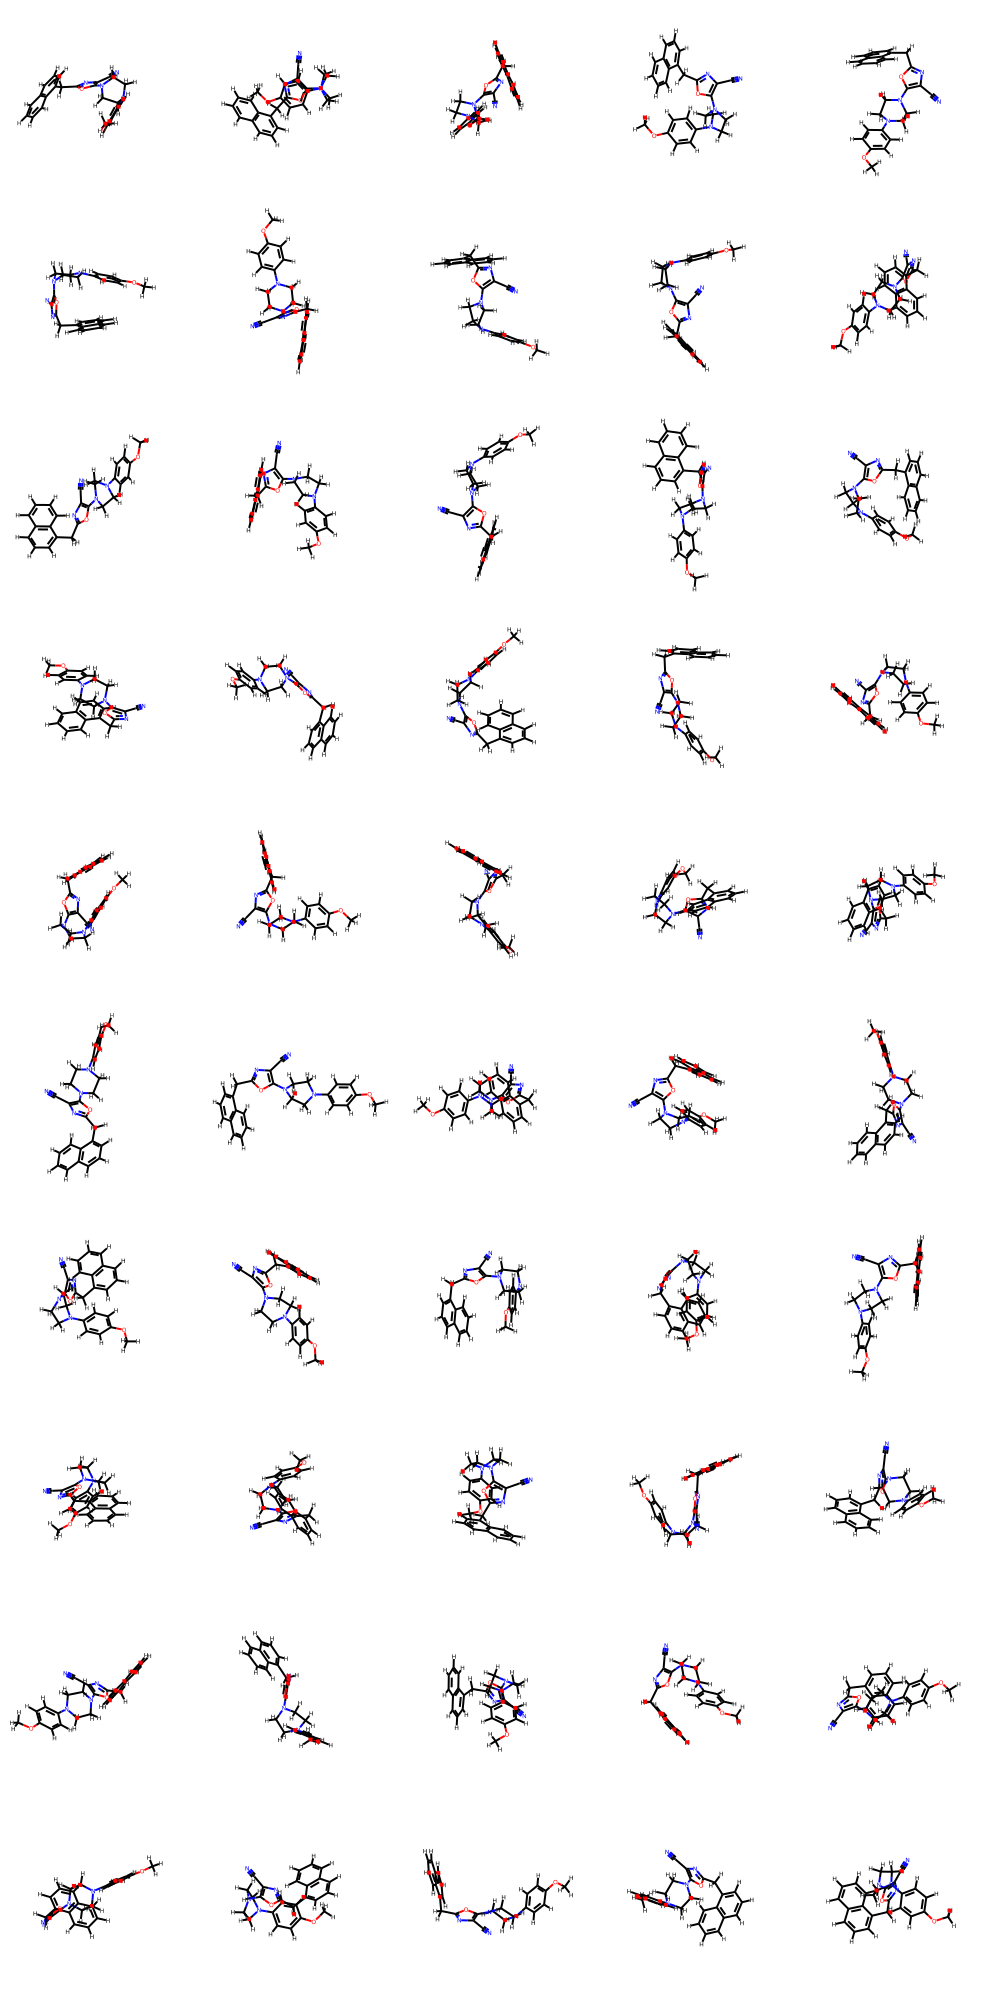

In [40]:
rdkit.Chem.Draw.MolsToGridImage(mol_trajs, molsPerRow=5, subImgSize=(200, 200))

In [41]:
torsion_list = enumerateTorsions(mol_trajs[0])
print(len(torsion_list))

70


In [42]:
k = 0
rdMolTransforms.GetDihedralDeg(mol.GetConformer(), *torsion_list[k])

175.3314371335146

### Check if conformers are cluttered altogether

In [43]:
pwise_distances = torch.stack([compute_distances(p) for p in pos], dim=0)

In [44]:
pwise_distances.shape

torch.Size([100, 1540])

In [45]:
median_distances = np.array([torch.median(compute_distances(p)).item() for p in pos])

(array([1., 2., 1., 2., 0., 2., 1., 3., 1., 2., 3., 1., 2., 3., 0., 2., 3.,
        3., 1., 1., 1., 1., 3., 1., 1., 8., 1., 0., 1., 5., 4., 4., 1., 5.,
        1., 6., 4., 3., 3., 1., 2., 1., 1., 1., 1., 3., 1., 0., 0., 2.]),
 array([4.95067263, 4.98114909, 5.01162556, 5.04210202, 5.07257849,
        5.10305495, 5.13353142, 5.16400788, 5.19448435, 5.22496081,
        5.25543728, 5.28591374, 5.31639021, 5.34686667, 5.37734314,
        5.4078196 , 5.43829607, 5.46877254, 5.499249  , 5.52972547,
        5.56020193, 5.5906784 , 5.62115486, 5.65163133, 5.68210779,
        5.71258426, 5.74306072, 5.77353719, 5.80401365, 5.83449012,
        5.86496658, 5.89544305, 5.92591951, 5.95639598, 5.98687244,
        6.01734891, 6.04782537, 6.07830184, 6.10877831, 6.13925477,
        6.16973124, 6.2002077 , 6.23068417, 6.26116063, 6.2916371 ,
        6.32211356, 6.35259003, 6.38306649, 6.41354296, 6.44401942,
        6.47449589]),
 <BarContainer object of 50 artists>)

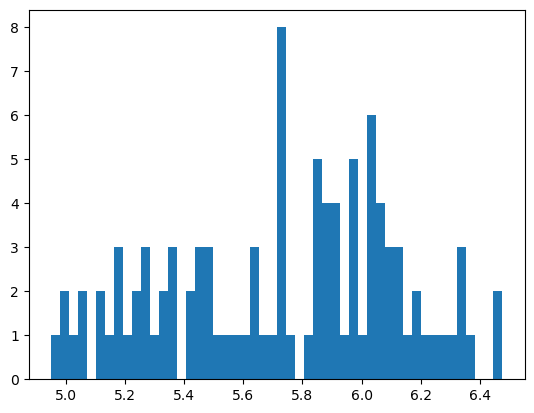

In [46]:
%matplotlib inline
plt.hist(median_distances, bins=50)

In [47]:
energies = np.array([compute_mmff_energy(mol) for mol in mol_trajs])

In [48]:
quantiles = np.quantile(energies, q=[0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

In [49]:
quantiles

array([219.89770577, 225.01897274, 229.70884585, 241.76277034,
       277.62429161, 566.60166552])

In [50]:
np.max(energies)

623.5498098811678

In [51]:
testdataset = datamodule.test_dataset

In [52]:
testdataframe = pd.DataFrame()
test_smiles = []
test_mols = []

In [53]:
for data in tqdm(testdataset, total=len(testdataset)):
    test_smiles.append(data.smiles)
    test_mols.append(data.mol)

100%|█████████████████████████████████████████████████████████████████████████| 103753/103753 [04:52<00:00, 355.13it/s]


In [54]:
testdataframe["smiles"] = test_smiles
testdataframe["mols"] = test_mols

In [55]:
testdataframe

,smiles,mols
0,C#CCNC(=O)C1=C[C@@H](c2ccc(Br)cc2)C[C@@H](OCc2...,<rdkit.Chem.rdchem.Mol object at 0x2ab8bd779a30>
1,C#CCNC(=O)C1=C[C@@H](c2ccc(Br)cc2)C[C@@H](OCc2...,<rdkit.Chem.rdchem.Mol object at 0x2ab8bd779eb0>
2,C#CCNC(=O)C1=C[C@@H](c2ccc(Br)cc2)C[C@@H](OCc2...,<rdkit.Chem.rdchem.Mol object at 0x2ab8b0c6fb70>
3,C#CCNC(=O)C1=C[C@@H](c2ccc(Br)cc2)C[C@@H](OCc2...,<rdkit.Chem.rdchem.Mol object at 0x2ab8bd77ceb0>
4,C#CCNC(=O)C1=C[C@@H](c2ccc(Br)cc2)C[C@@H](OCc2...,<rdkit.Chem.rdchem.Mol object at 0x2ab8bd77cd30>
...,...,...
103748,c1ccc(OCc2noc(CN3CC[C@H](C4CCCCC4)C3)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x2ab9ecde4cf0>
103749,c1ccc(OCc2noc(CN3CC[C@H](C4CCCCC4)C3)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x2ab9ecde4d30>
103750,c1ccc(OCc2noc(CN3CC[C@H](C4CCCCC4)C3)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x2ab9ecde4d70>
103751,c1ccc(OCc2noc(CN3CC[C@H](C4CCCCC4)C3)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x2ab9ecde4db0>


In [56]:
testdataframe["natoms"] = testdataframe["mols"].apply(lambda x: x.GetNumAtoms())

In [57]:
testdataframe["natoms"].unique()

array([ 51, 124,  42,  37,  29,  38,  39,  57,  53,  46,  41,  52,  26,
        40,  35,  48,  54,  43,  33,  67,  61,  45,  44,  36,  25,  24,
        68,  64,  87,  49,  21,  28,  27,  32,  62,  50,  73,  58,  47,
        59,  65,  69,  71,  55,  60,  70,  56,  76,  63,  31,  30,  34,
        72, 118, 108,  22,  17,  23,  19,  16,  18])

## Select one molecule

In [58]:
from pytorch_lightning import seed_everything

In [59]:
seed_everything(0)

Global seed set to 0


0

In [60]:
featurizer = MolFeaturization(dataset="drugs",
                              create_bond_graph=True,
                              save_smiles=True,
                              fully_connected_edge_index=True)

In [61]:
unique_smiles = testdataframe.smiles.unique()
print(len(unique_smiles))

1055


In [62]:
unique_smiles_dict = {}

In [63]:
for smi in tqdm(unique_smiles, total=len(unique_smiles)):
    subdf = testdataframe[testdataframe.smiles == smi]
    natoms = subdf["mols"].iloc[0].GetNumAtoms()
    unique_smiles_dict[smi] = (natoms, len(subdf))

100%|█████████████████████████████████████████████████████████████████████████████| 1055/1055 [00:05<00:00, 199.06it/s]


In [73]:
def generate_batch(data, num_repeat: int = 2, verbose: bool = False):
    repeated = repeat_batch(data, num_repeat=num_repeat).to(device)
    steps = model._hparams["num_diffusion_timesteps"]
    with torch.no_grad():
        pos, traj = model.reverse_sampling(x=repeated.xgeom,
                                           batch=repeated.batch,
                                           bond_edge_index=repeated.edge_index,
                                           bond_edge_attr=repeated.edge_attr,
                                           num_diffusion_timesteps=steps,
                                           verbose=verbose
                                          )
    batch_num_nodes = torch.bincount(repeated.batch)
    pos_graphs = torch.split(pos, batch_num_nodes.cpu().tolist(), dim=0)
    true_mols = repeated.mol
    gen_smiles = repeated.smiles
    gen_mols = [None for i in range(len(pos_graphs))]
    i = 0
    for true_mol, gen_pos in zip(true_mols, pos_graphs):
        gen_mols[i] = chem.set_rdmol_positions(deepcopy(true_mol), pos=gen_pos.detach().cpu().numpy())
        i += 1
    gen_df = pd.DataFrame()
    gen_df["smiles"] = gen_smiles
    gen_df["mols"] = gen_mols
    return gen_df

In [74]:
def evaluate_molecule(query_smiles, verbose: bool = True, q: float = 0.85, num_repeat: int = 2):
    query_df = testdataframe[testdataframe.smiles == query_smiles]
    query_df["graph"] = query_df.mols.apply(featurizer.featurize_smiles_or_mol)
    
    data = Batch.from_data_list(query_df.graph.tolist())
    gen_df = generate_batch(data, num_repeat=num_repeat, verbose=verbose)
    
    true_energies = np.array(query_df["mols"].apply(compute_mmff_energy))
    gen_energies = np.array(gen_df["mols"].apply(compute_mmff_energy))
    
    filter_out = np.quantile(gen_energies, [q])
    select = gen_energies < filter_out
    
    gen_energies_filtered = gen_energies[select]
    energies = {'true': true_energies, 'generated': gen_energies_filtered}
    fig, ax = plt.subplots()
    fig.suptitle("RDKit MMMF Energies")
    ax.boxplot(energies.values())
    ax.set_xticklabels(energies.keys())
    
    return gen_df, query_df

In [75]:
unique_smiles_dict

{'C#CCNC(=O)C1=C[C@@H](c2ccc(Br)cc2)C[C@@H](OCc2ccc(CO)cc2)O1': (51, 69),
 'C#CCOCCOCCOCCNc1nc(N2CCN(C(=O)[C@H](CCC(=O)O)n3cc([C@H](N)CO)nn3)CC2)nc(N2CCN(C(=O)[C@H](CCC(=O)O)n3cc([C@@H]([NH3+])CO)nn3)CC2)n1': (124,
  253),
 'C#CCOCCOCCOCCNc1nc(N2CCN(C(=O)[C@H](CCC(=O)O)n3cc([C@H]([NH3+])CO)nn3)CC2)nc(N2CCN(C(=O)[C@H](CCC(=O)O)n3cc([C@@H](N)CO)nn3)CC2)n1': (124,
  1),
 'C#Cc1ccc(C(=O)NCc2ccc(N3CCCC3=O)cc2)cc1': (42, 7),
 'C(=N/c1c(-c2ccccc2)nc2n1CCS2)\\c1ccccc1': (37, 4),
 'C(=N\\c1c(-c2ccccc2)nc2n1CCS2)\\c1ccccc1': (37, 4),
 'C/C(=N/NC(=O)c1ccc(Br)o1)c1ccc(C)o1': (29, 16),
 'C/C(=N\\NC(=S)NCc1ccccc1)c1ccc(Cl)cc1': (37, 22),
 'C/C(=N\\Nc1ccccn1)c1ccc(C(C)C)cc1': (38, 5),
 'C/C(=N\\OCC(=O)Nn1c(=O)[nH]c2ccccc2c1=O)c1cccs1': (39, 65),
 'C/C=C/C(=O)OCC(=O)Nc1c(Cl)cccc1Cl': (29, 30),
 'C/C=C/c1ccc(OCC(=O)Nc2cc(C(F)(F)F)ccc2N2CCOCC2)c(OC)c1': (57, 194),
 'C1CCN(c2nc(N3CCCCC3)nc(N3CCNCC3)n2)CC1': (53, 12),
 'C=CC[C@@](CC=C)(NC(=O)c1cccc(C)c1)c1ccccc1': (46, 243),
 'C=CCN(c1ccccc1C(=O)O)S(=O)(=

In [76]:
testdataframe_stats = pd.DataFrame()
testdataframe_stats["smiles"] = list(unique_smiles_dict.keys())
testdataframe_stats["natoms"] = [a[0] for a in unique_smiles_dict.values()]
testdataframe_stats["nconformers"] = [a[1] for a in unique_smiles_dict.values()]

In [77]:
testdataframe_stats = testdataframe_stats.sort_values(by=["natoms"], ascending=False).reset_index(drop=True)

In [78]:
testdataframe_stats

,smiles,natoms,nconformers
0,C#CCOCCOCCOCCNc1nc(N2CCN(C(=O)[C@H](CCC(=O)O)n...,124,253
1,C#CCOCCOCCOCCNc1nc(N2CCN(C(=O)[C@H](CCC(=O)O)n...,124,1
2,CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(O)c5c(c(...,118,107
3,CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c5c(...,108,94
4,CC(C)(C)OC(=O)NCCCC[C@H](NC(=O)c1nc[nH]c1C(=O)...,87,360
...,...,...,...
1050,Cn1ccc(NC(=O)CCl)n1,19,12
1051,O=C(O)[C@@H](O)c1ccccc1,19,4
1052,NC(=S)Nc1ccc(F)c(F)c1F,18,4
1053,C[n+]1cccc(C(=O)[O-])c1,17,5


In [79]:
testdataframe_stats.iloc[40].smiles

'Cc1coc2c(C)c3oc(=O)c(CCC(=O)N4C[C@@H]5C[C@H](C4)Cn4c5cccc4=O)c(C)c3cc12'

In [80]:
torch.cuda.empty_cache() 

range(0, 300)


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:08<00:00, 37.01it/s]


(31, 4) (62, 2)


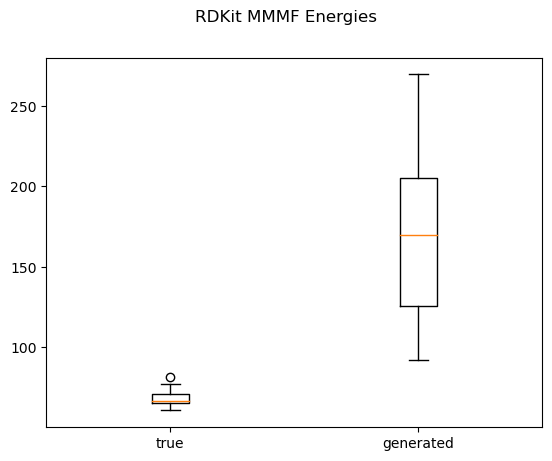

In [89]:
gen_df, true_df = evaluate_molecule(query_smiles=testdataframe_stats.iloc[40].smiles,
                                    q=0.8, num_repeat=2)
print(true_df.shape, gen_df.shape)

In [93]:
viewer = MolTo3DView(gen_df["mols"].iloc[10], size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [91]:
viewer = MolTo3DView(true_df["mols"].iloc[0], size=(600, 300), style='stick')
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [87]:
def get_rmsd_confusion_matrix(true_mols, gen_mols):
    num_ref = len(true_mols)
    num_gen = len(gen_mols)
    rmsd_confusion_mat = -1 * np.ones([num_ref, num_gen], dtype=np.float)    
    for i, gen_mol in enumerate(gen_mols):
        for j, true_mol in enumerate(true_mols):
            rmsd_confusion_mat[j, i] = get_best_rmsd(gen_mol, true_mol)
    return rmsd_confusion_mat

def evaluate_generated_confs(true_mols, gen_mols, threshold: float = 0.5):
    rmsd_confusion_mat = get_rmsd_confusion_matrix(true_mols, gen_mols)
    rmsd_ref_min = rmsd_confusion_mat.min(-1)
    a, b = (rmsd_ref_min<=threshold).mean(), rmsd_ref_min.mean()
    return a, b

In [88]:
evaluate_generated_confs(true_df["mols"], gen_df["mols"], threshold=0.75)

(0.06451612903225806, 1.4255299449623002)

## Alanine Dipeptide

In [94]:
smiles = "CC(C(=O)NC(C)C(=O)O)N"
data = featurizer.featurize_smiles_or_mol(smiles).to(device)
mol = data.mol
mol

conf = Chem.Conformer(mol.GetNumAtoms())
for i in range(mol.GetNumAtoms()):
    conf.SetAtomPosition(i, (np.random.rand(3,)))
mol.AddConformer(conf)

0

In [95]:
data

Data(x=[23, 5], edge_index=[2, 44], edge_attr=[44], atom_elements=[23], xgeom=[23], mol=<rdkit.Chem.rdchem.Mol object at 0x2ab9ee1d3d00>, smiles='CC(N)C(=O)NC(C)C(=O)O')

In [96]:
nrepeats = 100
batch = repeat_data(data, num_repeat=nrepeats)

In [97]:
steps = model._hparams["num_diffusion_timesteps"]
with torch.no_grad():
    pos, traj = model.reverse_sampling(x=batch.xgeom,
                                       batch=batch.batch,
                                       bond_edge_index=batch.edge_index,
                                       bond_edge_attr=batch.edge_attr,
                                       num_diffusion_timesteps=steps,
                                       save_traj=True, verbose=True)
pos_sde_traj, pos_mean_traj = traj

range(0, 300)


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 58.86it/s]


In [98]:
pos = torch.stack(pos.chunk(nrepeats, dim=0))
pos = pos.cpu()
mol_trajs = [None for i in range(len(pos))]
for i, p in enumerate(pos):
    mol_trajs[i] = chem.set_rdmol_positions(deepcopy(mol), pos=p.detach().cpu().numpy())

In [99]:
interact(conf_viewer, idx=ipywidgets.IntSlider(min=0, max=len(mol_trajs) - 1, step=1))

interactive(children=(IntSlider(value=0, description='idx', max=99), Output()), _dom_classes=('widget-interact…

<function __main__.conf_viewer(idx)>

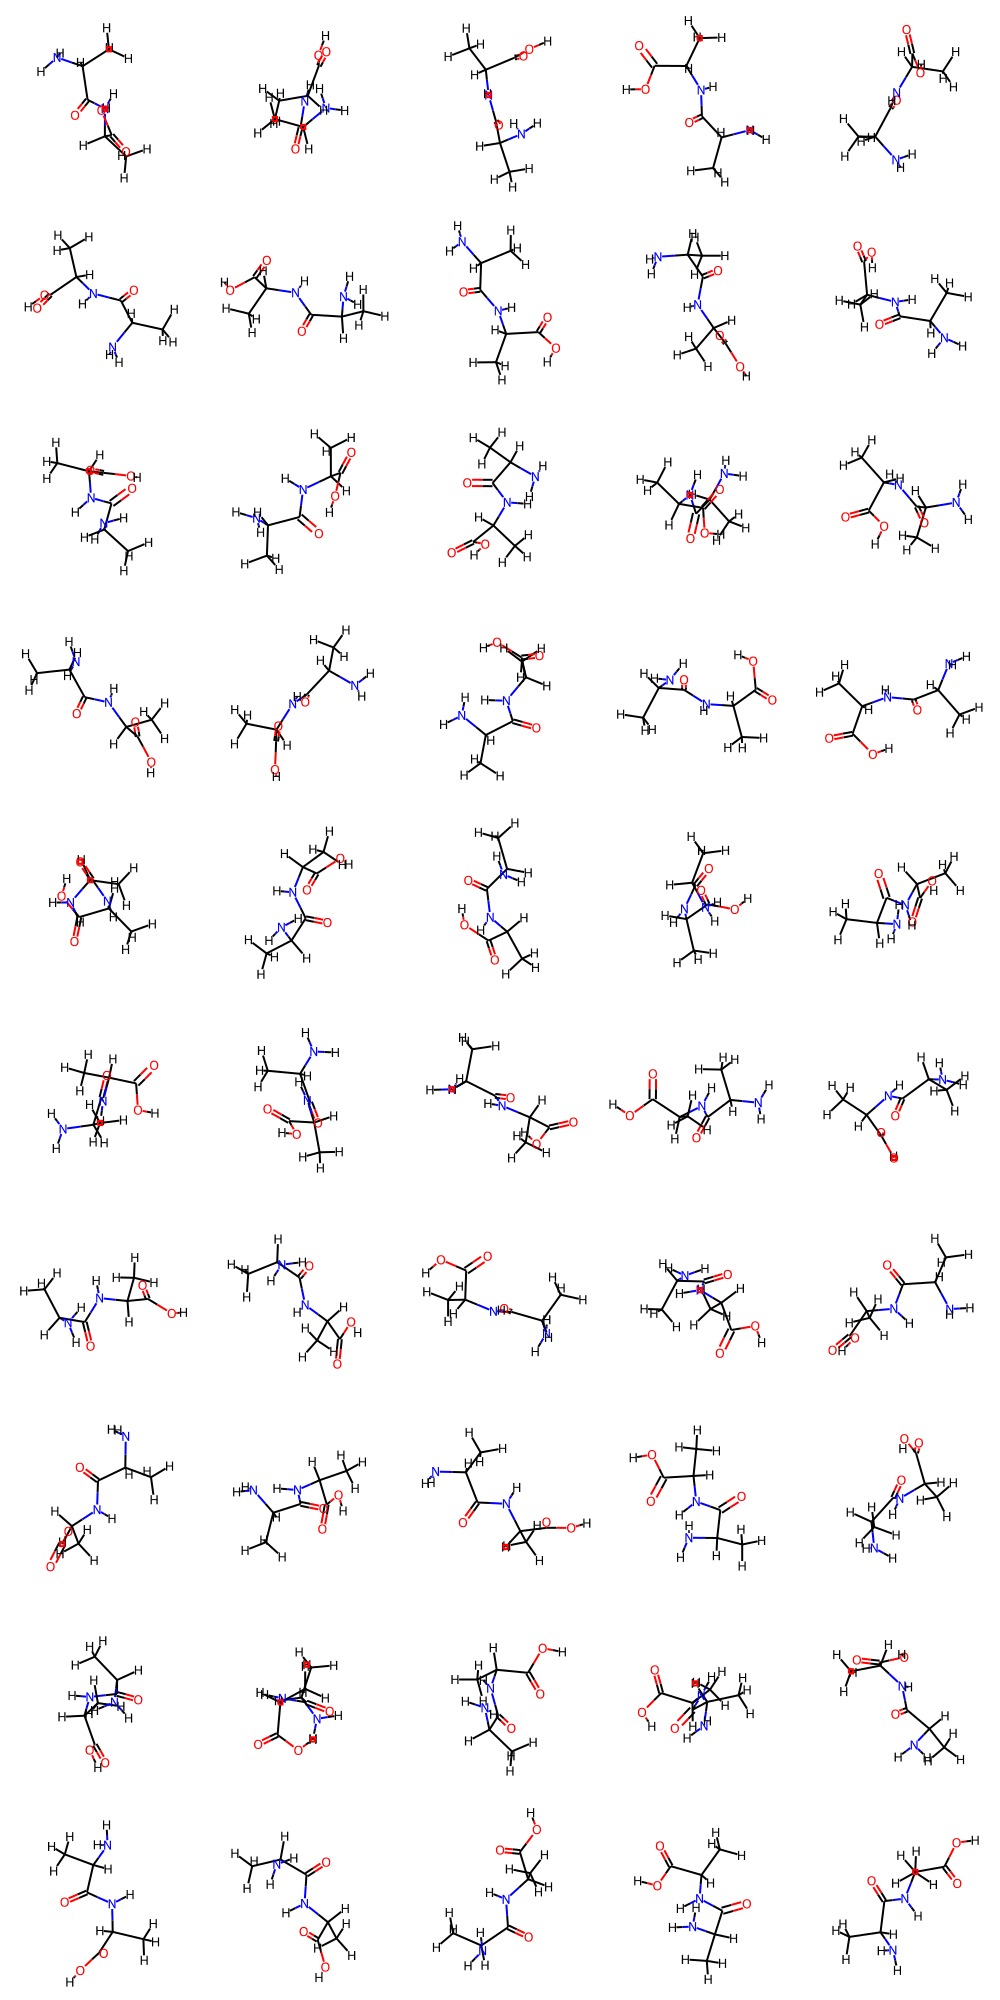

In [100]:
rdkit.Chem.Draw.MolsToGridImage(mol_trajs, molsPerRow=5, subImgSize=(200, 200))

In [101]:
energies = np.array([compute_mmff_energy(m) for m in mol_trajs])

In [102]:
energies

array([45.77012986, 35.94990494, 40.96758017, 41.57849197, 44.19575636,
       34.70399356, 44.22681905, 56.96867434, 40.27233968, 38.62939354,
       43.64037898, 39.26280183, 44.67100588, 34.47838513, 51.45543775,
       35.67203727, 38.2100312 , 47.36121416, 50.78648405, 39.7342925 ,
       39.95162463, 42.58576982, 46.88656887, 52.33981651, 34.05687562,
       34.67594337, 44.82524145, 62.56717626, 44.53137085, 40.48065878,
       36.11388062, 45.31858015, 50.09614411, 50.5858407 , 39.7868009 ,
       35.5441965 , 49.2742217 , 39.9975057 , 42.25848615, 42.37745659,
       44.28526759, 36.68351089, 55.13841634, 42.90916704, 47.0823395 ,
       39.10223603, 40.60238038, 37.40242633, 45.0563424 , 34.18312515,
       41.11910331, 38.75221652, 35.79783968, 43.66248392, 36.69847995,
       53.76281738, 39.87943562, 43.66862956, 50.49432257, 42.07547448,
       37.25575681, 35.34661991, 43.11183059, 38.37975065, 39.43585137,
       45.98554264, 37.11662397, 37.06663613, 45.39000522, 40.45

In [103]:
dihedrals = enumerateTorsions(mol_trajs[0])
print(dihedrals)

[(13, 0, 1, 2), (13, 0, 1, 10), (13, 0, 1, 14), (14, 1, 2, 3), (14, 1, 2, 4), (14, 1, 10, 21), (14, 1, 10, 22), (4, 2, 4, 5), (4, 2, 4, 15), (15, 4, 5, 6), (15, 4, 5, 7), (15, 4, 5, 16), (16, 5, 6, 17), (16, 5, 6, 18), (16, 5, 6, 19), (16, 5, 7, 8), (16, 5, 7, 9), (9, 7, 9, 20)]
